## LOADING DATA FROM CORA

In [3]:
# coding: utf8
import xarray as xr
import pandas as pd
import numpy as np
import glob
import os
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from pyxpcm import pcm
import hvplot.xarray

ROOT='/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/PROFILES/'
path=glob.glob(os.path.join(ROOT+'*_TEMP_*.nc'))
path.sort()
DAT=xr.open_mfdataset(path,decode_times=False)  
#remove some remaining NaNs
remnan=np.unique(np.argwhere(np.isnan(DAT.temp.values))[:,0])
DAT=DAT.where(~DAT.N_PROF.isin(remnan),drop=True)
#JULD to date
DAT['date']=xr.DataArray(np.array(pd.to_datetime(DAT.juld.values,unit='D',origin=pd.to_datetime('1950/1/1')),dtype='datetime64'),dims='N_PROF')

#SUBSEL SUMMER MONTH
c1=xr.DataArray(pd.to_datetime(DAT.date.values).month>=5,dims='N_PROF')
c2=xr.DataArray(pd.to_datetime(DAT.date.values).month<=9,dims='N_PROF')
DAT=DAT.where(c1&c2,drop=True)

DAT

<xarray.Dataset>
Dimensions:          (DEPTH: 140, N_PROF: 60842)
Coordinates:
  * DEPTH            (DEPTH) int64 5 10 15 20 25 30 ... 675 680 685 690 695 700
Dimensions without coordinates: N_PROF
Data variables:
    temp             (N_PROF, DEPTH) float64 dask.array<shape=(60842, 140), chunksize=(39, 140)>
    juld             (N_PROF) float64 dask.array<shape=(60842,), chunksize=(39,)>
    wmo_inst_type    (N_PROF) object dask.array<shape=(60842,), chunksize=(39,)>
    longitude        (N_PROF) float64 dask.array<shape=(60842,), chunksize=(39,)>
    platform_number  (N_PROF) object dask.array<shape=(60842,), chunksize=(39,)>
    latitude         (N_PROF) float64 dask.array<shape=(60842,), chunksize=(39,)>
    date             (N_PROF) datetime64[ns] 1950-05-04T13:00:00.000028800 ... 2017-09-30T22:45:31.000003200

## LOADING TRAINING DATASET

In [2]:
# From this new dataset, create a more uniform subset to train PCM
# 3 random profiles per 1/2° x 1/2° grid cell, per month
train_ds = xr.open_dataset('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/train_ds_gs_prf.nc')
train_ds['date']=xr.DataArray(np.array(pd.to_datetime(train_ds.juld.values,unit='D',origin=pd.to_datetime('1950/1/1')),dtype='datetime64'),dims='N_PROF')

#SUBSEL SUMMER MONTHS
c1=xr.DataArray(pd.to_datetime(train_ds.date.values).month>=5,dims='N_PROF')
c2=xr.DataArray(pd.to_datetime(train_ds.date.values).month<=9,dims='N_PROF')
train_ds=train_ds.where(c1&c2,drop=True)

train_ds

<xarray.Dataset>
Dimensions:    (DEPTH: 140, N_PROF: 9991)
Coordinates:
  * DEPTH      (DEPTH) int64 5 10 15 20 25 30 35 ... 670 675 680 685 690 695 700
Dimensions without coordinates: N_PROF
Data variables:
    latitude   (N_PROF) float64 28.62 28.48 28.63 29.83 ... 44.6 44.87 44.37
    longitude  (N_PROF) float64 -78.37 -78.73 -78.6 ... -35.93 -35.59 -35.3
    temp       (N_PROF, DEPTH) float64 26.44 26.38 26.33 ... 8.559 8.49 8.422
    juld       (N_PROF) float64 9.28e+03 9.277e+03 ... 2.326e+04 1.89e+04
    date       (N_PROF) datetime64[ns] 1975-05-29T18:00:00 ... 2001-09-25T00:40:59.999980800

## PLOT THE TRAINING DATASET PER MONTH TO SHOW HOMOGENEITY OVER THE YEAR

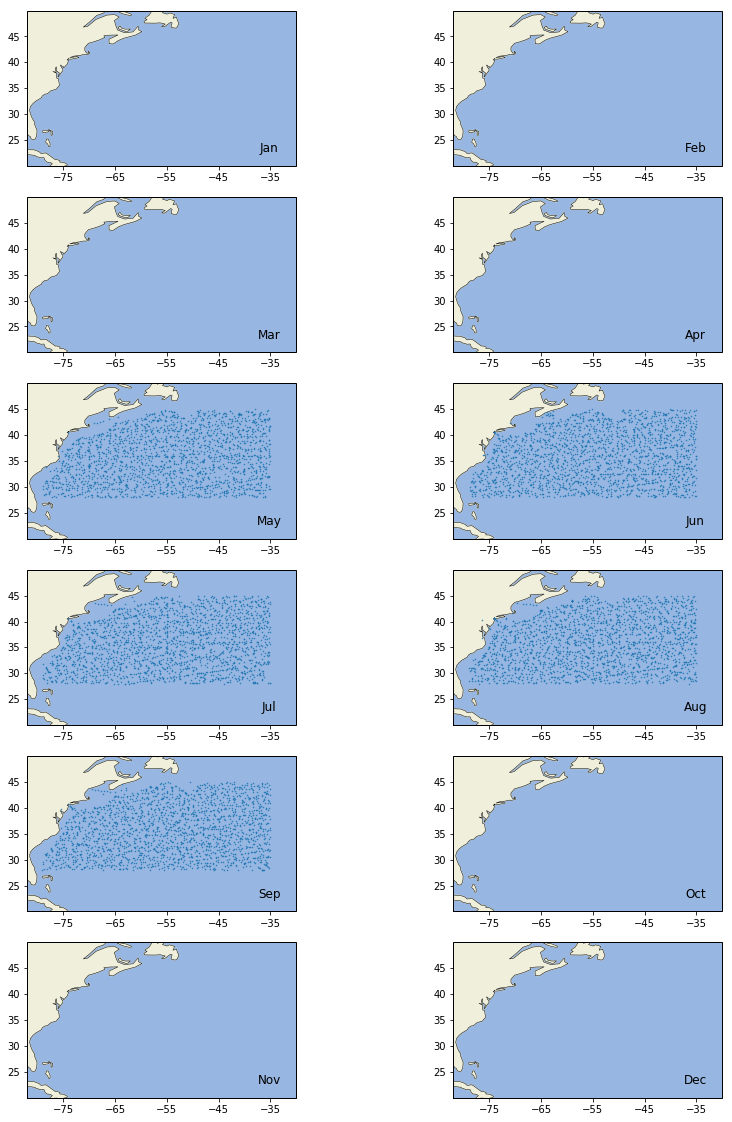

In [4]:
fig = plt.figure(figsize=(14,20))
mproj=ccrs.PlateCarree()
mname=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for monthi in range(12):
    cond=xr.DataArray(pd.to_datetime(train_ds.date.values).month==monthi+1,dims='N_PROF')
    az = fig.add_subplot(6, 2, monthi+1, projection=mproj)
    az.set_extent([-82, -30, 20, 50], crs=mproj)
    az.add_feature(cfeature.OCEAN)
    az.add_feature(cfeature.LAND)
    az.add_feature(cfeature.COASTLINE, linewidth=0.5)
    az.set_xticks(range(-75,-30,10), crs=mproj)
    az.set_yticks(range(25,50,5), crs=mproj)
    az.set_title(mname[monthi],x=0.9,y=0.05)
    az.plot(train_ds.where(cond,drop=True).longitude,train_ds.where(cond,drop=True).latitude,'.',markersize=1.0)        

## PLOT GLOBAL DS VERSUS TRAIN DS

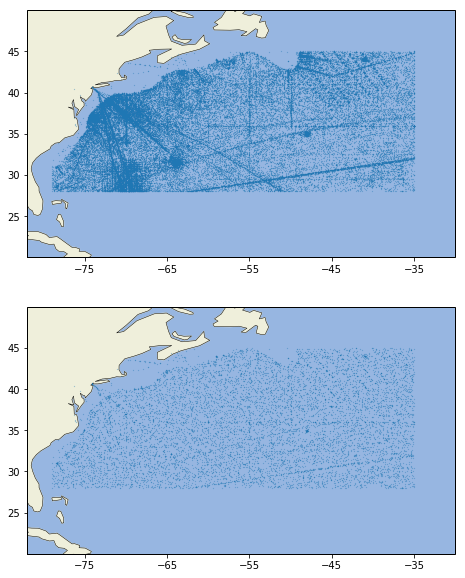

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10,10))
mproj=ccrs.PlateCarree()

ax = fig.add_subplot(2, 1, 1, projection=mproj)
ax.set_extent([-82, -30, 20, 50], crs=mproj)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_xticks(range(-75,-30,10), crs=mproj)
ax.set_yticks(range(25,50,5), crs=mproj)
ax.plot(DAT.longitude,DAT.latitude,'.',markersize=0.3)

az = fig.add_subplot(2, 1, 2, projection=mproj)
az.set_extent([-82, -30, 20, 50], crs=mproj)
az.add_feature(cfeature.OCEAN)
az.add_feature(cfeature.LAND)
az.add_feature(cfeature.COASTLINE, linewidth=0.5)
az.set_xticks(range(-75,-30,10), crs=mproj)
az.set_yticks(range(25,50,5), crs=mproj)
az.plot(train_ds.longitude,train_ds.latitude,'.',markersize=0.3)
plt.show()

## BIC CALCULATION

128  independant points
0
100


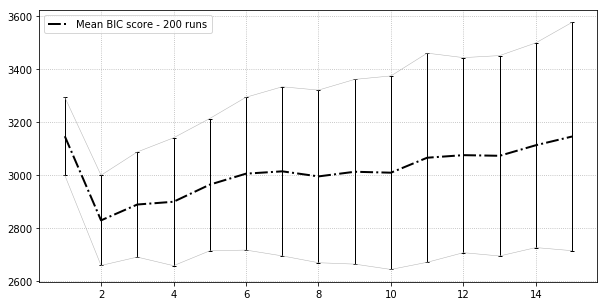

In [7]:
#BIC SIMULATION TO DECIDE HOW MANY CLUSTERS WE USE
kmax = 15   #number of clusters max
ntry = 200  #number of simulation per cluster
#init
BIC = np.zeros([ntry,kmax])
BICr= np.zeros([ntry,kmax])
#Number of independant points : Surface of the quadrangle / surface of a circle r=150km (argo corelation radius)
Sg=(6370**2)*(79-35)*(np.pi/180)*(np.sin(45)-np.sin(28))
decorrelation_radius=150 #km
Cg=2*np.pi*(decorrelation_radius**2)
n=int(np.round(Sg/Cg))
print n,' independant points'

for lt in range(ntry):    
    if(np.mod(lt,100)==0):
        print lt    
    randsel=np.random.choice(range(len(train_ds.N_PROF)),n,False)    
    subtrain=train_ds.where(train_ds.N_PROF.isin(randsel),drop=True)    
    for k in range(kmax):
        m = pcm(K=k+1, feature_axis=np.arange(5,700,5), feature_name='temperature')
        A=m.fit(subtrain, feature={'temperature': 'temp'})        
        llih=m.score(subtrain, feature={'temperature': 'temp'})        
        Xn=m.preprocessing(subtrain,feature={'temperature':'temp'})
        #D=Dimension de la decomposition verticale des profiles (EOF)
        D = Xn.shape[1]
        Nf = (k+1)-1 + (k+1)*D + (k+1)*D*(D+1)/2
        BIC[lt,k] = -2*n*llih + Nf*np.log(n) #    
        BICr[lt,k]= m._classifier.bic(Xn)
                 
plt.figure(figsize=(10,5))
h1=plt.errorbar(np.arange(kmax)+1, np.mean(BIC,axis=0), yerr=np.std(BIC,axis=0),fmt='k-.',linewidth=2,
                ecolor='k',elinewidth=1,capsize=2,capthick=1)
plt.plot(np.arange(kmax)+1, np.mean(BIC,axis=0)+np.std(BIC,axis=0),linewidth=0.5,color=[0.7]*3)
plt.plot(np.arange(kmax)+1, np.mean(BIC,axis=0)-np.std(BIC,axis=0),linewidth=0.5,color=[0.7]*3)
plt.gca().grid(linestyle=':')
plt.legend(h1,['Mean BIC score - '+str(ntry)+' runs'])


## GO CLASSIF

In [53]:
#SO WE CHOOSE N CLUSTERS TO CLASSIFY PROFILES
Knum=4
m = pcm(K=Knum, feature_axis=np.arange(5,700,5), feature_name='temperature')
m.fit(train_ds, feature={'temperature': 'temp'})

#THEN WE CLASSIFY ALL THE PROFILES
LABELS2=m.predict(DAT, feature={'temperature': 'temp'})
POSTS2=m.predict_proba(DAT, feature={'temperature': 'temp'})

## REARANGING CLUSTERS TO KEEP THINGS SORTED

In [9]:
# #REARANGE CLUSTERS SO WE ALWAYS HAVE THE SAME ORDER
# NEWK=np.zeros(4)*np.nan
# #CLUSTER 1 : SMALLEST SPREAD AT 150m
# spr=np.zeros(4)
# for k in range(4):
#     mi=DAT.where((LABELS==k)&(DAT.DEPTH==150),drop=True).temp.min().values
#     ma=DAT.where((LABELS==k)&(DAT.DEPTH==150),drop=True).temp.max().values
#     spr[k]=ma-mi
# NEWK[0]=np.argmin(spr)    
# #CLUSTER 2 : LARGEST SPREAD OVER PROFILE
# lsp=np.zeros(4)
# for k in range(4):
#     mi=DAT.where((LABELS==k),drop=True).temp.min('N_PROF').mean().values
#     ma=DAT.where((LABELS==k),drop=True).temp.max('N_PROF').mean().values
#     lsp[k]=ma-mi
# NEWK[1]=np.argmax(lsp)    
# #CLUSTER 3 : SMALLEST DELTA T BETWEEN 0-700m
# mdt=np.zeros(4)
# for k in range(4):
#     mi=DAT.where((LABELS==k)&(DAT.DEPTH==700),drop=True).temp.mean().values
#     ma=DAT.where((LABELS==k)&(DAT.DEPTH==5),drop=True).temp.mean().values
#     mdt[k]=ma-mi
# NEWK[2]=np.argmin(mdt)    
# #CLUSTER 4 : THE ONE WE HAVE LEFT
# NEWK[np.isnan(NEWK)]=6-np.sum(NEWK[~np.isnan(NEWK)])
# print 'NEW CLUSTER ORDER =',NEWK
    
# LABELS2=xr.DataArray(np.empty_like(LABELS.values),dims='N_PROF',attrs=LABELS.attrs)
# POSTS2=xr.DataArray(np.empty_like(POSTS.values),dims=['N_PROF','N_CLASS'],attrs=POSTS.attrs)
# for k in range(4):
#     LABELS2[LABELS==k]=(np.zeros(len(LABELS[LABELS==k]))+np.argwhere(NEWK==k))[0,:]
#     POSTS2[:,k]=POSTS[:,np.int(np.argwhere(NEWK==k))]    

#REARANGE CLUSTERS SO WE ALWAYS HAVE THE SAME ORDER
NEWK=np.zeros(4)*np.nan
#CLUSTER 1 : SMALLEST SPREAD AT 200m
spr=np.zeros(4)
for k in range(4):
    mi=DAT.where((LABELS==k)&(DAT.DEPTH==200),drop=True).temp.min().values
    ma=DAT.where((LABELS==k)&(DAT.DEPTH==200),drop=True).temp.max().values
    spr[k]=ma-mi
NEWK[0]=np.argmin(spr)    
#CLUSTER 2 : SMALLEST SPREAD AT 695m
lsp=np.zeros(4)
for k in range(4):
    mi=DAT.where((LABELS==k)&(DAT.DEPTH==695),drop=True).temp.min().values
    ma=DAT.where((LABELS==k)&(DAT.DEPTH==695),drop=True).temp.max().values
    lsp[k]=ma-mi
NEWK[1]=np.argmin(lsp)    
#CLUSTER 3 : LARGEST SPREAD OVERALL
mdt=np.zeros(4)
for k in range(4):
    mi=DAT.where((LABELS==k),drop=True).temp.min('N_PROF').mean().values
    ma=DAT.where((LABELS==k),drop=True).temp.max('N_PROF').mean().values
    mdt[k]=ma-mi
NEWK[2]=np.argmax(mdt)    
#CLUSTER 4 : THE ONE WE HAVE LEFT
NEWK[np.isnan(NEWK)]=6-np.sum(NEWK[~np.isnan(NEWK)])
print 'NEW CLUSTER ORDER =',NEWK
   
LABELS2=xr.DataArray(np.empty_like(LABELS.values),dims='N_PROF',attrs=LABELS.attrs)
POSTS2=xr.DataArray(np.empty_like(POSTS.values),dims=['N_PROF','N_CLASS'],attrs=POSTS.attrs)

for k in range(4):
    LABELS2[LABELS==k]=(np.zeros(len(LABELS[LABELS==k]))+np.argwhere(NEWK==k))[0,:]
    POSTS2[:,k]=POSTS[:,np.int(np.argwhere(NEWK==k))]       


NEW CLUSTER ORDER = [0. 3. 1. 2.]


## PLOT PROFILES TO CHECK CLUSTERS

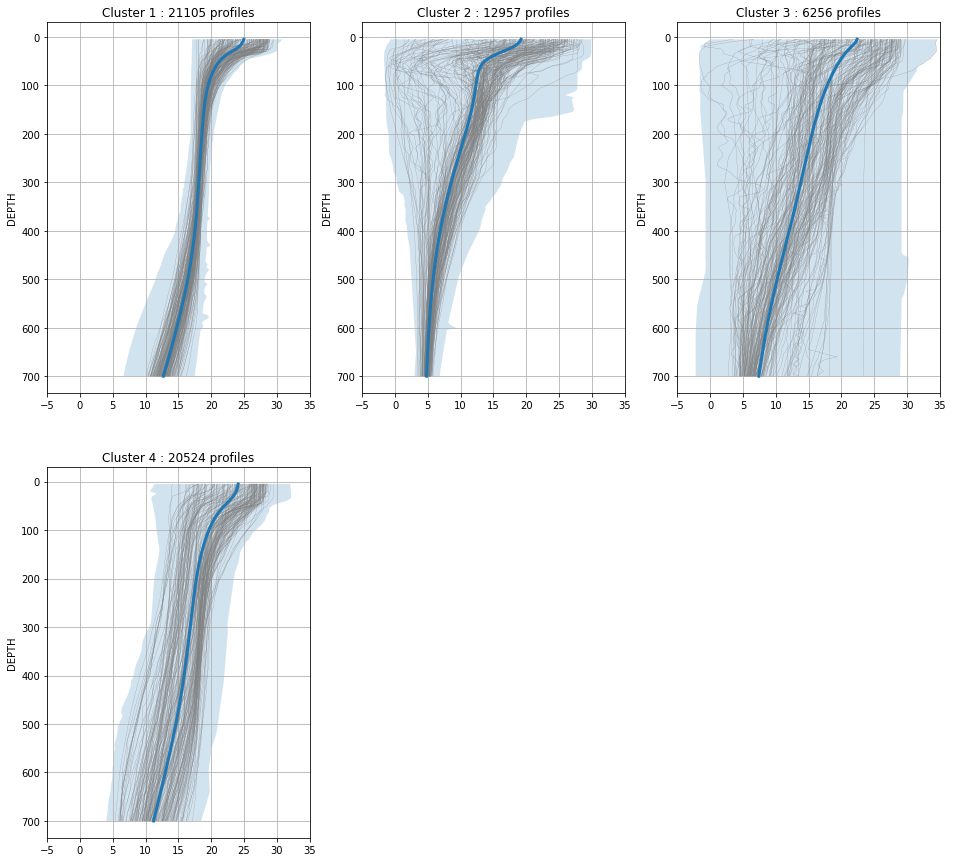

In [54]:
%matplotlib inline
#DISPLAY CLUSTER EVERY MONTH 
fig=plt.figure(figsize=(16,15))

for k in range(Knum):    
    ax = fig.add_subplot(2, 3,(k+1))       
    SDAT=DAT.temp.where((LABELS2==k)&(POSTS2.max(dim='N_CLASS')>0.9),drop=True)        
    SDAT[np.random.randint(0,len(SDAT)-1,200)].plot.line(y='DEPTH',linewidth=0.2,color='gray')
    SDAT.mean('N_PROF').plot.line(y='DEPTH',linewidth=3)  
    ax.fill_betweenx(DAT.DEPTH.values,SDAT.min(dim='N_PROF').values,SDAT.max(dim='N_PROF').values,alpha=0.2)    
    ax.set_xlim(-5,35)
    ax.invert_yaxis()
    ax.get_legend().remove()
    ax.grid()
    ax.set_title('Cluster '+str(k+1)+' : '+str(len(DAT.longitude[LABELS2==k]))+' profiles')          
#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/PNG/JJA_4clusters/profiles.png')

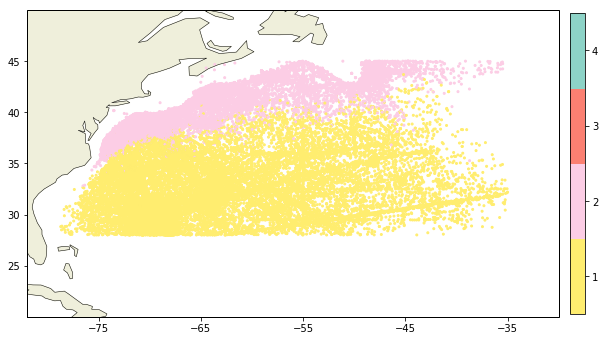

In [20]:
%matplotlib inline
#DISPLAY CLUSTERIZD DATA EVERY MONTH TO SEARCH FOR SEASONNAL PATTERNS

ccm = plt.cm.get_cmap('Set3_r', Knum)
mproj=ccrs.PlateCarree()
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1,1, projection=mproj)
ax.set_extent([-82, -30, 20, 50], crs=mproj)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_xticks(range(-75,-30,10), crs=mproj)
ax.set_yticks(range(25,50,5), crs=mproj)    
sc=ax.scatter(DAT.longitude.where(LABELS2<2),DAT.latitude.where(LABELS2<2),s=4,alpha=1,c=LABELS2.where(LABELS2<2)+1,cmap=ccm,vmin=0.5,vmax=Knum+0.5)
plt.colorbar(sc, fraction=0.027, pad=0.02,ticks=np.arange(1,Knum+1))    
#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/PNG/JJA_4clusters/cluster_map.png')

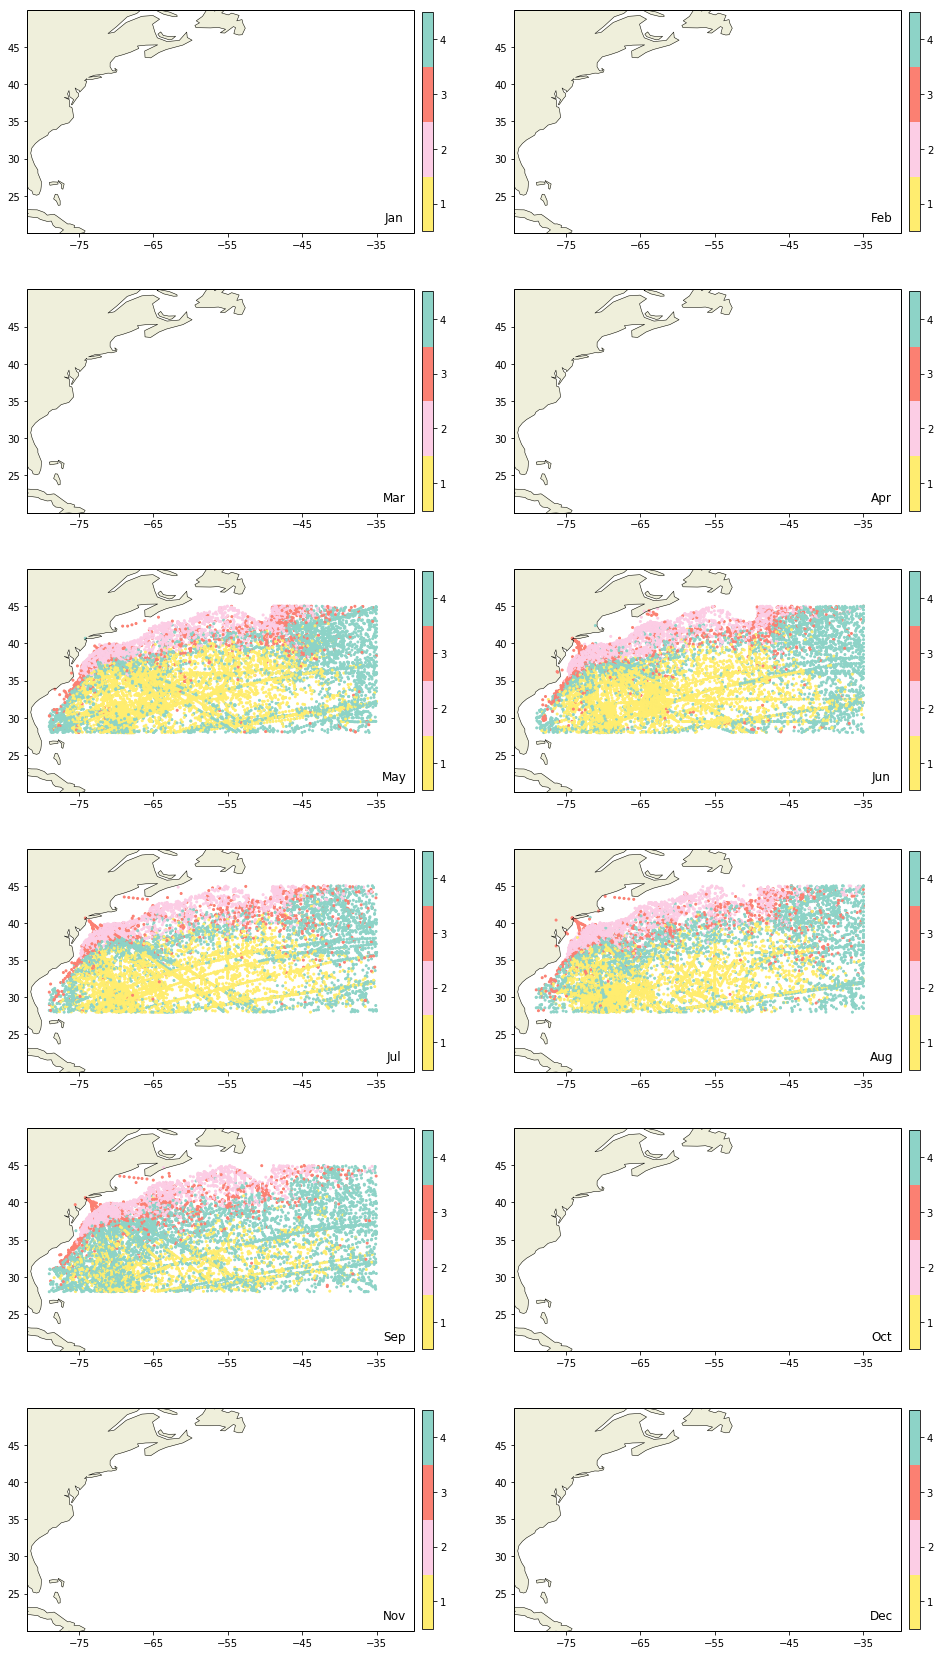

In [11]:
%matplotlib inline
#DISPLAY CLUSTERIZD DATA EVERY MONTH TO SEARCH FOR SEASONNAL PATTERNS

ccm = plt.cm.get_cmap('Set3_r', Knum)
mproj=ccrs.PlateCarree()
fig=plt.figure(figsize=(16,30))
mname=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for k in range(12):        
    ax = fig.add_subplot(6, 2,(k+1), projection=mproj)
    ax.set_extent([-82, -30, 20, 50], crs=mproj)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_xticks(range(-75,-30,10), crs=mproj)
    ax.set_yticks(range(25,50,5), crs=mproj)    
    cond1=xr.DataArray((pd.to_datetime(DAT.date.values).month==k+1),dims='N_PROF')
    idp=(POSTS2.max(dim='N_CLASS')>0.3)&(cond1)    
    sc=ax.scatter(DAT.longitude[idp],DAT.latitude[idp],s=4,alpha=1,c=LABELS2[idp]+1,cmap=ccm,vmin=0.5,vmax=Knum+0.5)
    plt.colorbar(sc, fraction=0.027, pad=0.02,ticks=np.arange(1,Knum+1))    
    ax.set_title(mname[k],x=0.95,y=0.025)
plt.show()
#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/4clusters_monthly_distribution.png')

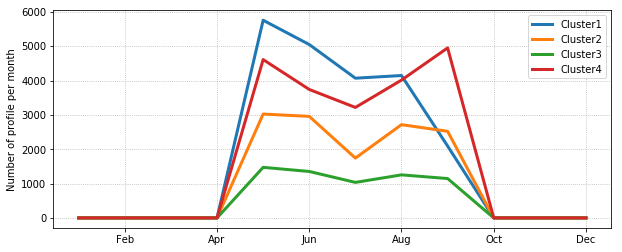

In [21]:
#NB PROFILE OVER A YEAR
allmonth=np.arange(1,13)
NBP=np.zeros([4,12])
for i in allmonth:
    cond=xr.DataArray(pd.to_datetime(DAT.date.values).month==i,dims='N_PROF')
    for j in range(Knum):
            NBP[j,i-1]=len(DAT.where(cond&(LABELS2==j),drop=True).N_PROF)
            
plt.figure(figsize=(10,4))
for j in range(Knum):
    plt.plot(allmonth,NBP[j,:],linewidth=3)
plt.legend(['Cluster1','Cluster2','Cluster3','Cluster4'])    
plt.grid(linestyle=':')
plt.ylabel('Number of profile per month')
plt.xticks([2,4,6,8,10,12])
plt.gca().set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])
#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/YearlyClusterSampling.png')
plt.show()

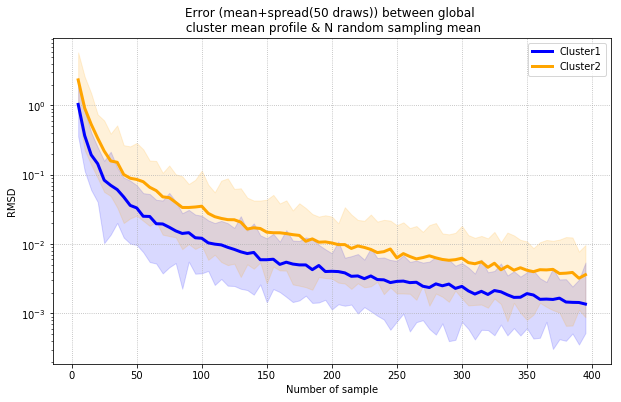

In [89]:
# #RMS BETWEEN GLOBAL MEAN AND MEAN FROM RANDOM SAMPLING
# ntry=50
# clusters=[0,1]

# RMST=np.zeros([ntry,len(clusters),len(np.arange(5,400,5))])
# RMSM=np.zeros([ntry,len(clusters),len(np.arange(5,400,5))])

# for k in range(len(clusters)):
#     print 'Cluster',k        
#     for ti in range(ntry):        
#         SDAT=DAT.where(LABELS2==clusters[k],drop=True)        
#         SPOST=POSTS2.where(LABELS2==clusters[k],drop=True).values[:,clusters[k]]
#         GMEAN=np.average(SDAT.temp.values,axis=0,weights=SPOST)
#         ind=0
#         for i in np.arange(5,400,5):                
#             sel=np.random.choice(range(len(SDAT.N_PROF)),i,False)
#             TSEL=SDAT.temp[sel,:]    
#             TPOST=SPOST[sel]
#             AA=GMEAN-np.average(TSEL.values,axis=0,weights=TPOST)
#             RMST[ti,k,ind]=np.sqrt(np.sum(AA**2))/i        
#             ind+=1
            
# RMSM=RMST.mean(axis=0)        

plt.figure(figsize=(10,6))
col=['blue','orange']
for j in range(len(clusters)):
    plt.semilogy(np.arange(5,400,5),RMSM[j,:],linewidth=3,color=col[j])
    plt.fill_between(np.arange(5,400,5),RMST[:,j,:].min(axis=0),RMST[:,j,:].max(axis=0),color=col[j],alpha=0.15)
plt.legend(['Cluster1','Cluster2'])    
plt.grid(linestyle=':')
plt.title('Error (mean+spread(50 draws)) between global \n cluster mean profile & N random sampling mean')
plt.ylabel('RMSD')
plt.xlabel('Number of sample')

#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/PNG/JJA_4clusters/RMSD.png')   

In [60]:
# TIME SERIE
ally=np.arange('1950','2018',dtype='datetime64[Y]')
seuil_np=30 # MINIMUM NUMBER OF POINTS TO GENERATE MEAN
d1=150      # MIN DEPTH
d2=450      # MAX DEPTH

#GLOBAL MEAN PROFILE FOR CLUSTER K
c1=xr.DataArray(pd.to_datetime(DAT.date.values).month>=5,dims='N_PROF')
c2=xr.DataArray(pd.to_datetime(DAT.date.values).month<=9,dims='N_PROF')
c12=(c1&c2)
c3=DAT.date>np.datetime64('1950-01-01')

#MEAN C1
GPOST_a=POSTS2.where(c12&c3&(LABELS2==0),drop=True).values[:,0]
GMEAN_a=np.average(DAT.temp.where(c12&c3&(DAT.DEPTH>=d1)&(DAT.DEPTH<=d2)&(LABELS2==0),drop=True).values,axis=0,weights=GPOST_a)
#MEAN C2
GPOST_b=POSTS2.where(c12&c3&(LABELS2==1),drop=True).values[:,1]
GMEAN_b=np.average(DAT.temp.where(c12&c3&(DAT.DEPTH>=d1)&(DAT.DEPTH<=d2)&(LABELS2==1),drop=True).values,axis=0,weights=GPOST_b)
#MEAN CG
GPOST_g=POSTS2.where(c12&c3&((LABELS2==0)|(LABELS2==1)),drop=True).values[:,[0,1]].max(axis=1)
GMEAN_g=np.average(DAT.temp.where(c12&c3&(DAT.DEPTH>=d1)&(DAT.DEPTH<=d2)&((LABELS2==0)|(LABELS2==1)),drop=True).values,axis=0,weights=GPOST_g)

#INIT
AC_a=np.zeros([len(GMEAN_a),len(ally)])*np.nan
NB_a=np.zeros(len(ally))
AC_b=np.zeros([len(GMEAN_b),len(ally)])*np.nan
NB_b=np.zeros(len(ally))
AC_g=np.zeros([len(GMEAN_g),len(ally)])*np.nan
NB_g=np.zeros(len(ally))

for y in range(len(ally)):
    #1    
    SDAT_a=DAT.where((DAT.date>=ally[y])&(DAT.date<ally[y]+1)&c12&(DAT.DEPTH>=d1)&(DAT.DEPTH<=d2)&(LABELS2==0),drop=True)     
    SPOS_a=POSTS2.where((DAT.date>=ally[y])&(DAT.date<ally[y]+1)&c12&(LABELS2==0),drop=True).values[:,0]
    #2
    SDAT_b=DAT.where((DAT.date>=ally[y])&(DAT.date<ally[y]+1)&c12&(DAT.DEPTH>=d1)&(DAT.DEPTH<=d2)&(LABELS2==1),drop=True) 
    SPOS_b=POSTS2.where((DAT.date>=ally[y])&(DAT.date<ally[y]+1)&c12&(LABELS2==1),drop=True).values[:,1] 
    #G
    SDAT_g=DAT.where((DAT.date>=ally[y])&(DAT.date<ally[y]+1)&c12&(DAT.DEPTH>=d1)&(DAT.DEPTH<=d2)&((LABELS2==0)|(LABELS2==1)),drop=True) 
    SPOS_g=POSTS2.where((DAT.date>=ally[y])&(DAT.date<ally[y]+1)&c12&((LABELS2==0)|(LABELS2==1)),drop=True).values[:,[0,1]].max(axis=1)
    
    #1
    NB_a[y]=len(SDAT_a.N_PROF)
    if(NB_a[y]>seuil_np):        
        AC_a[:,y]=np.average(SDAT_a.temp.values,axis=0,weights=SPOS_a)-GMEAN_a            
    #2        
    NB_b[y]=len(SDAT_b.N_PROF)        
    if(NB_b[y]>seuil_np):        
        AC_b[:,y]=np.average(SDAT_b.temp.values,axis=0,weights=SPOS_b)-GMEAN_b
    #G    
    NB_g[y]=len(SDAT_g.N_PROF)
    if(NB_a[y]>seuil_np):        
        AC_g[:,y]=np.average(SDAT_g.temp.values,axis=0,weights=SPOS_g)-GMEAN_g                    

<IPython.core.display.Javascript object>


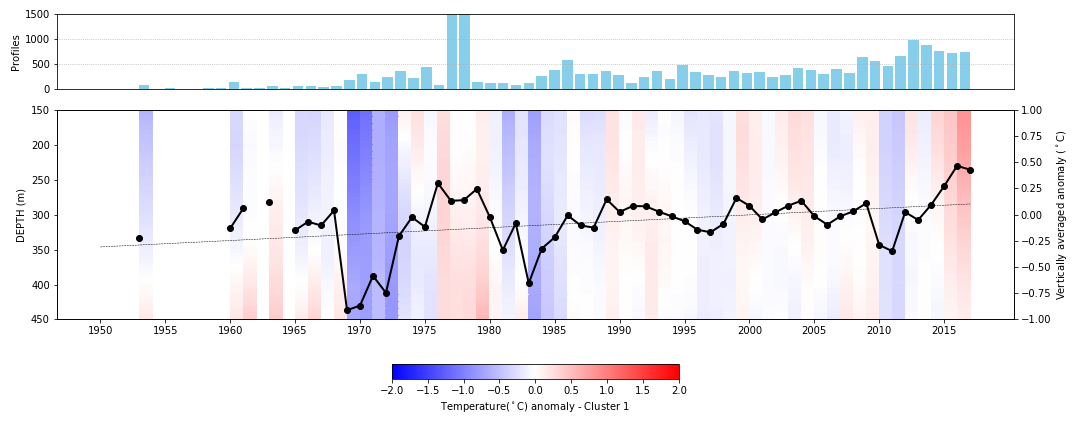

<IPython.core.display.Javascript object>


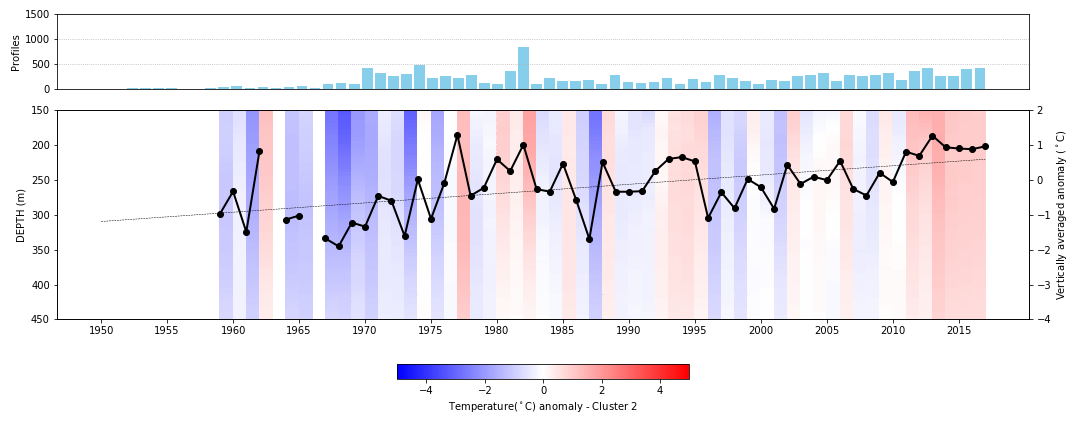

<IPython.core.display.Javascript object>


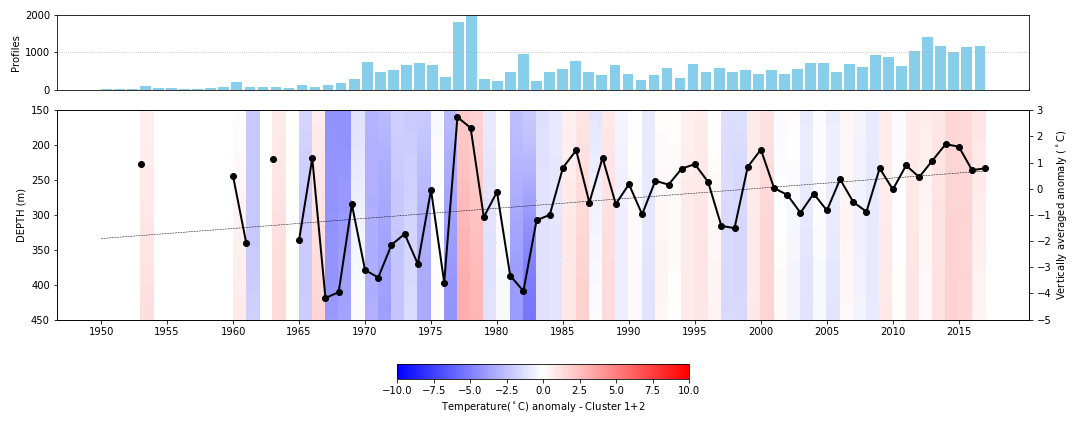

In [62]:
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 

fig=plt.figure(figsize=(15,6))
ax0=plt.subplot(gs[0])
ax0.bar(ally,NB_a,300,color='SkyBlue')
ax0.set_xticks([])
ax0.set_ylabel('Profiles')
ax0.grid(linestyle=':')
ax0.set_ylim([0,1500])
ax1=plt.subplot(gs[1])
sc=ax1.pcolor(ally,SDAT_a.DEPTH,AC_a,cmap='bwr',vmin=-2,vmax=2)
ax1.invert_yaxis()
ax1.set_ylabel('DEPTH (m)')
cb=plt.colorbar(sc, orientation='horizontal',shrink=0.3)
cb.set_label('Temperature($^\circ$C) anomaly - Cluster 1')
ax1b=ax1.twinx()
ax1b.plot(ally,AC_a.mean(axis=0),'k-o',linewidth=2)
ax1b.set_ylim([-1,1])
ax1b.set_ylabel('Vertically averaged anomaly ($^\circ$C)')
ax1b.set_xticks(np.arange('1950','2020',dtype='datetime64[5Y]'))
p=np.polyfit(np.arange(1,len(ally)+1)[~np.isnan(AC_a.mean(axis=0))],AC_a.mean(axis=0)[~np.isnan(AC_a.mean(axis=0))],deg=1)
ax1b.plot(ally,p[1]+p[0]*np.arange(1,len(ally)+1),'k--',linewidth=0.5)
fig.tight_layout()
#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/PNG/JJA_4clusters/TimeSerie_Cluster_1.png')

fig=plt.figure(figsize=(15,6))
az0=plt.subplot(gs[0])
az0.bar(ally,NB_b,300,color='SkyBlue')
az0.set_xticks([])
az0.set_ylabel('Profiles')
az0.grid(linestyle=':')
az0.set_ylim([0,1500])
az1=plt.subplot(gs[1])
sc=az1.pcolor(ally,SDAT_b.DEPTH,AC_b,cmap='bwr',vmin=-5,vmax=5)
az1.invert_yaxis()
az1.set_ylabel('DEPTH (m)')
cb=plt.colorbar(sc, orientation='horizontal',shrink=0.3)
cb.set_label('Temperature($^\circ$C) anomaly - Cluster 2')
az1b=az1.twinx()
az1b.plot(ally,AC_b.mean(axis=0),'k-o',linewidth=2)
az1b.set_ylim([-4,2])
az1b.set_ylabel('Vertically averaged anomaly ($^\circ$C)')
az1b.set_xticks(np.arange('1950','2020',dtype='datetime64[5Y]'))
p=np.polyfit(np.arange(1,len(ally)+1)[~np.isnan(AC_b.mean(axis=0))],AC_b.mean(axis=0)[~np.isnan(AC_b.mean(axis=0))],deg=1)
az1b.plot(ally,p[1]+p[0]*np.arange(1,len(ally)+1),'k--',linewidth=0.5)
fig.tight_layout()
#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/PNG/JJA_4clusters/TimeSerie_Cluster_2.png')

fig=plt.figure(figsize=(15,6))
aw0=plt.subplot(gs[0])
aw0.bar(ally,NB_g,300,color='SkyBlue')
aw0.set_xticks([])
aw0.set_ylabel('Profiles')
aw0.grid(linestyle=':')
aw0.set_ylim([0,2000])
aw1=plt.subplot(gs[1])
sc=aw1.pcolor(ally,SDAT_g.DEPTH,AC_g,cmap='bwr',vmin=-10,vmax=10)
aw1.invert_yaxis()
aw1.set_ylabel('DEPTH (m)')
cb=plt.colorbar(sc, orientation='horizontal',shrink=0.3)
cb.set_label('Temperature($^\circ$C) anomaly - Cluster 1+2')
aw1b=aw1.twinx()
aw1b.plot(ally,AC_g.mean(axis=0),'k-o',linewidth=2)
aw1b.set_ylim([-5,3])
aw1b.set_ylabel('Vertically averaged anomaly ($^\circ$C)')
aw1b.set_xticks(np.arange('1950','2020',dtype='datetime64[5Y]'))
p=np.polyfit(np.arange(1,len(ally)+1)[~np.isnan(AC_g.mean(axis=0))],AC_g.mean(axis=0)[~np.isnan(AC_g.mean(axis=0))],deg=1)
aw1b.plot(ally,p[1]+p[0]*np.arange(1,len(ally)+1),'k--',linewidth=0.5)
fig.tight_layout()
#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/PNG/JJA_4clusters/TimeSerie_Cluster_1_2.png')

## MAPPING THE FRONT BETWEEN CLUSTER USING SCIKIT LEARN SVM LIB

<IPython.core.display.Javascript object>


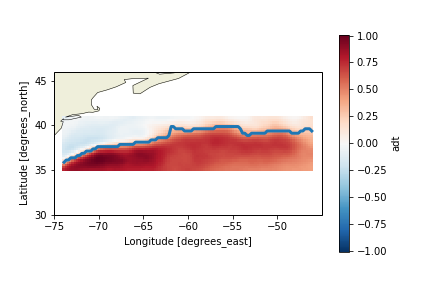

In [30]:
%matplotlib notebook

#GET GULFSTREAM POSITION FROM GLORYS (100-700m, 1993-2014)
AVI1=xr.open_dataset('/export/home1/DATA/ALTIMETRY/dataset-duacs-rep-global-merged-allsat-phy-l4_1995-2005.nc')
AVI2=xr.open_dataset('/export/home1/DATA/ALTIMETRY/dataset-duacs-rep-global-merged-allsat-phy-l4_2005-2015.nc')
AVI=xr.concat([AVI1,AVI2],dim='time')

c1=xr.DataArray(pd.to_datetime(AVI.time.values).month>=5,dims='time')
c2=xr.DataArray(pd.to_datetime(AVI.time.values).month<=9,dims='time')
c12=(c1&c2)

AVI=AVI.where(c12&(AVI.latitude>35)&(AVI.latitude<41)&(AVI.longitude>-74+360)&(AVI.longitude<-46+360),drop=True)
AVI=AVI.mean(['time'])
GSssh=np.zeros_like(AVI.longitude.values)

for ix in range(len(AVI.longitude)):
    a=np.zeros_like(AVI.latitude.values)    
    a[1:-2]=AVI.adt.values[2:-1,ix]-AVI.adt.values[0:-3,ix]        
    GSssh[ix]=AVI.latitude.values[np.argmin(a[~np.isnan(a)])]            
    #GSssh[ix]=AVI.latitude.values[np.argmax(AVI.uo.values[~np.isnan(AVI.uo.values[:,ix]),ix])]
    
fig=plt.figure()
ax = fig.add_subplot(1, 1,1, projection=mproj)  
ax.set_extent([-75, -45, 32, 46], crs=mproj)    
ax.add_feature(cfeature.LAND)    
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)        
ax.set_xticks(range(-75,-45,5), crs=mproj)
ax.set_yticks(range(30,50,5), crs=mproj)    
ax.plot(AVI.longitude-360,GSssh,'-',linewidth=3)   
AVI.adt.plot()

<IPython.core.display.Javascript object>


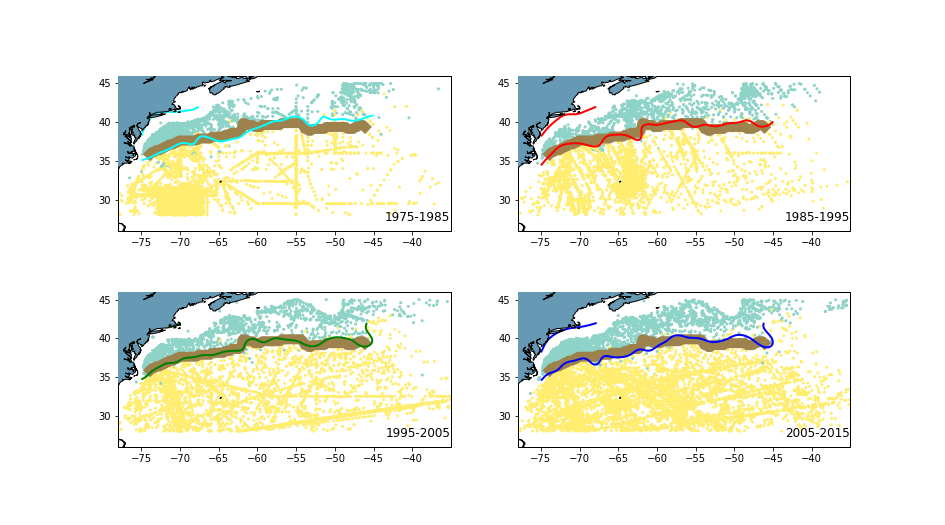

In [59]:
%matplotlib notebook

from sklearn import svm
from matplotlib.lines import Line2D

TI=np.array(['1975','1985','1995','2005'],dtype='datetime64[Y]')
#TI=np.array(['1995'],dtype='datetime64[Y]')
c1=(LABELS2<2)

ccm = plt.cm.get_cmap('Set3_r', 2)
mproj=ccrs.PlateCarree()
fig=plt.figure()
#ax = fig.add_subplot(1, 1,1, projection=mproj)
#LAND
ne_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])

col=['cyan','red','green','blue']
ifz=0

for y in TI:
    c2=(DAT.date>=y)&(DAT.date<y+10)   
    X=np.stack((DAT.longitude.where(c1&c2,drop=True).values,DAT.latitude.where(c1&c2,drop=True).values),axis=-1)
    Y=LABELS2.where(c1&c2,drop=True).values    
    W=POSTS2.where(c1&c2,drop=True).values[:,[0,1]].max(axis=1)
    
    # fit the model
    clf = svm.SVC(kernel='rbf',gamma='auto')    
    clf.fit(X, Y, sample_weight=W)

    # plot the decision function for each datapoint on the grid
    xx, yy = np.meshgrid(np.linspace(-75, -45, 200),np.linspace(28, 42, 100))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #        
    ax = fig.add_subplot(2, 2,ifz+1, projection=mproj)
    ax.add_feature(ne_feature, edgecolor='black',zorder=10)
    ax.set_extent([-78, -35, 26, 46], crs=mproj)       
    ax.set_xticks(range(-75,-35,5), crs=mproj)
    ax.set_yticks(range(30,50,5), crs=mproj)    
    ax.scatter(X[:,0],X[:,1],s=4,alpha=1,c=Y,cmap=ccm,label=None,zorder=1)        
    ax.plot(AVI.longitude-360,GSssh,'-',linewidth=10,color=[.615,.510,.306],zorder=2)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2,linetypes='-',colors=col[ifz],zorder=3)       
    #ax.contourf(xx, yy, Z, levels=[-1,1], alpha=0.25 , colors=col[ifz])            
    ax.set_title(str(TI[ifz])+'-'+str(TI[ifz]+10),x=0.9,y=0.025)    
    ifz=ifz+1    
    
# legend_elements = [Line2D([0], [0], color=col[0], lw=2, label=str(TI[0])+'-'+str(TI[0]+10)),
#                    Line2D([0], [0], color=col[1], lw=2, label=str(TI[1])+'-'+str(TI[1]+10)),
#                    Line2D([0], [0], color=col[2], lw=2, label=str(TI[2])+'-'+str(TI[2]+10)),
#                    Line2D([0], [0], color=col[3], lw=2, label=str(TI[3])+'-'+str(TI[3]+10)),
#                    Line2D([0], [0], linestyle='-', color=[.615,.510,.306],lw=10, label='GulfStream from altimetry')]

# # legend
# ax.legend(handles=legend_elements, loc='lower right') 

#plt.savefig('/home1/ballycotton/DATA/PIRATE/CORA/GulfStream/PNG/JJA_4clusters/GulfStream_Position_per_decade_sup.png')